In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve

## Data Unpacking

In [2]:
class DataProcessing:
    
    def __init__(self, filepath):
        self.dataframe = pd.read_csv(filepath)
        
    def permutate_data(self, seed):
        np.random.seed(seed)
        indx = np.random.permutation(self.dataframe.shape[0])
        self.dataframe = self.dataframe.iloc[indx]
        
    def get_target(self, target_feature):
        self.target = self.dataframe[target_feature]
        self.features = self.dataframe.drop(columns=target_feature)
        return self.features, self.target
        
    def split_data(self, test_part, target_feature):
        features, target = self.get_target(target_feature)
        val = int(self.dataframe.shape[0] * test_part)
        return features[val : ].values, features[ : val].values, target[val : ].values, target[ : val].values

In [3]:
processing = DataProcessing(filepath = './bioresponse.csv')
processing.permutate_data(1000)
x_train, x_test, y_train, y_test = processing.split_data(0.3, 'Activity')

In [4]:
unique, counts = np.unique(processing.dataframe['Activity'].values, return_counts=True)
dict([zip(unique, counts)])

{(0, 1717): (1, 2034)}

In [5]:
def tn (label, preds):
    return confusion_matrix(label, preds).ravel()[0]
def fp (label, preds):
    return confusion_matrix(label, preds).ravel()[1]
def fn (label, preds):
    return confusion_matrix(label, preds).ravel()[2]
def tp (label, preds):
    return confusion_matrix(label, preds).ravel()[3]

## Training 

In [6]:
models = [DecisionTreeClassifier(max_depth=5),
          DecisionTreeClassifier(max_depth=25),
          RandomForestClassifier(max_depth=5),
          RandomForestClassifier(max_depth=25), ]

metrics = [precision_score, 
           recall_score, 
           accuracy_score, 
           f1_score, 
           log_loss, 
           tn, fp, fn, tp, ]

possible_curves = [precision_recall_curve, 
                   roc_curve, ]

scorers = {model : {metric : None for metric in metrics} for model in models}
curves = {model : {curve : None for curve in possible_curves} for model in models}

for model in scorers.keys():
    model.fit(x_train, y_train)
    predicts = model.predict(x_test)
    predict_probas = model.predict_proba(x_test)
    #predicts = (predict_probas[:, 1] < 0.8).astype(int)
    
    for curve in curves[model].keys():
        curves[model][curve] = curve(y_test, predict_probas[:, 1], pos_label = 1)
    
    for metric in scorers[model].keys():
        scorers[model][metric] = metric(y_test, predicts)
        
resultframe = pd.DataFrame([[value for value in metric.values()] for metric in list(scorers.values())],
                           index = list(map(lambda x: f"{x.__class__.__name__}___max_depth={x.max_depth}", scorers.keys())),
                           columns = list(map(lambda x: x.__name__, scorers[models[0]].keys())))
resultframe

,precision_score,recall_score,accuracy_score,f1_score,log_loss,tn,fp,fn,tp
DecisionTreeClassifier___max_depth=5,0.751914,0.807566,0.752000,0.778747,8.565732,355,162,117,491
DecisionTreeClassifier___max_depth=25,0.702290,0.756579,0.695111,0.728424,10.530628,322,195,148,460
RandomForestClassifier___max_depth=5,0.762602,0.771382,0.746667,0.766966,8.749927,371,146,139,469
RandomForestClassifier___max_depth=25,0.778481,0.809211,0.772444,0.793548,7.859590,377,140,116,492


## Visualizing result

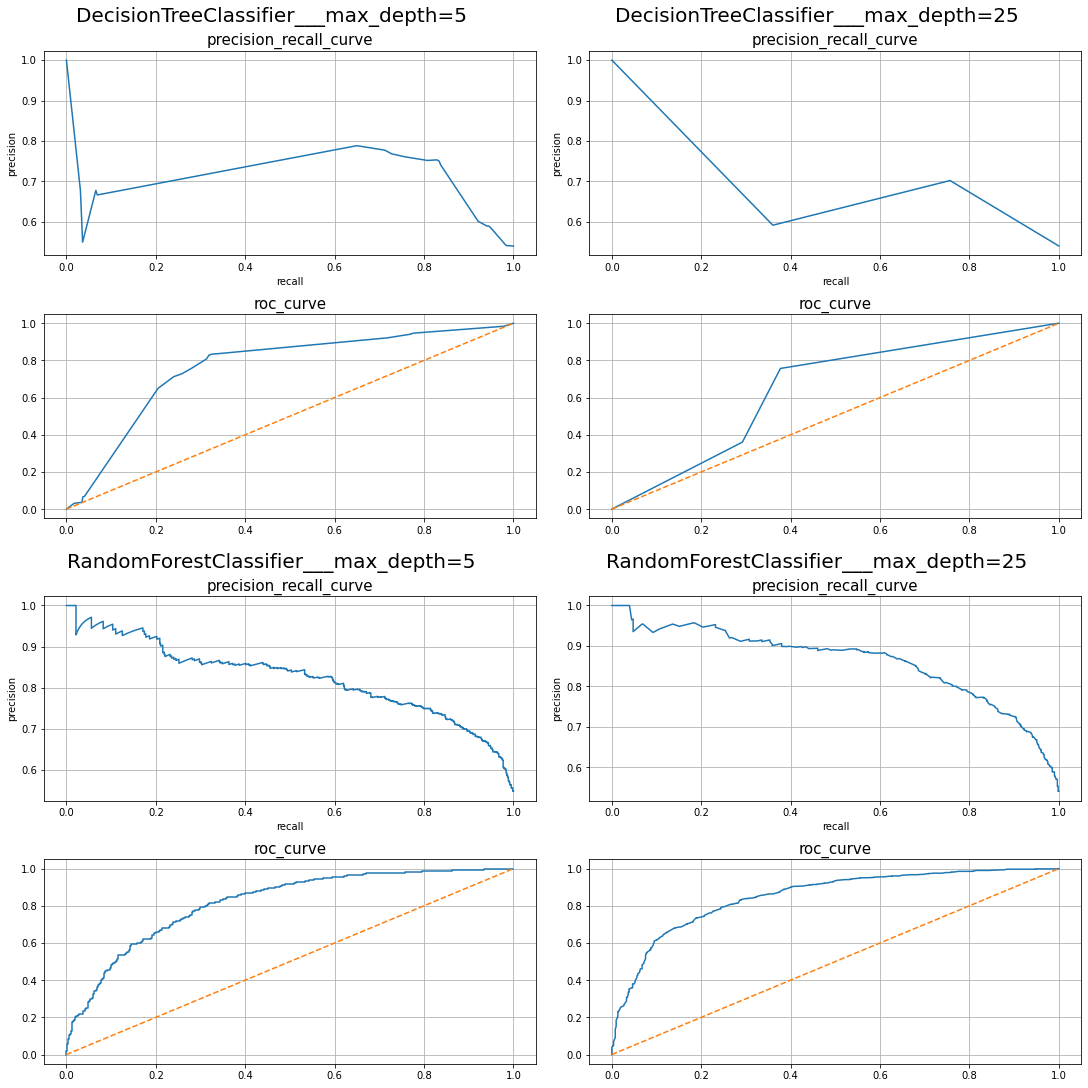

In [7]:
fig = plt.figure(figsize=(15, 15), constrained_layout=True)

subfigs = fig.subfigures(2, 2)

for model, (outerind, subfig) in zip(curves.keys(), enumerate(subfigs.flat)):
    subfig.suptitle(f"{model.__class__.__name__}___max_depth={model.max_depth}", fontsize=20)
    axs = subfig.subplots(2, 1)
    for curve, (innerind, ax) in zip(curves[model].keys(), enumerate(axs.flat)):
        ax.set_title(curve.__name__, fontsize=15)
        if curve.__name__[:3] == 'roc':
            ax.plot(curves[model][curve][0], curves[model][curve][1])
            ax.plot(curves[model][curve][1], curves[model][curve][1], '--')
        else:
            ax.plot(curves[model][curve][1], curves[model][curve][0])
            ax.set_xlabel('recall', fontsize=10)
            ax.set_ylabel('precision', fontsize=10)
            
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid()

## Lets make recall metric much higher

Setting up weights 

In [8]:
models = [DecisionTreeClassifier(max_depth=5, class_weight={0 : 0.5, 1 : 10.}),
          DecisionTreeClassifier(max_depth=25, class_weight={0 : 0.5, 1 : 10.}),
          RandomForestClassifier(max_depth=5, class_weight={0 : 0.5, 1 : 10.}),
          RandomForestClassifier(max_depth=25, class_weight={0 : 0.5, 1 : 10.}), ]

metrics = [precision_score, 
           recall_score, 
           accuracy_score, 
           f1_score, 
           log_loss, 
           tn, fp, fn, tp, ]

possible_curves = [precision_recall_curve, 
                   roc_curve, ]

scorers = {model : {metric : None for metric in metrics} for model in models}
curves = {model : {curve : None for curve in possible_curves} for model in models}

for model in scorers.keys():
    model.fit(x_train, y_train)
    predicts = model.predict(x_test)
    predict_probas = model.predict_proba(x_test)
        
    for curve in curves[model].keys():
        curves[model][curve] = curve(y_test, predict_probas[:, 1], pos_label = 1)
    
    for metric in scorers[model].keys():
        scorers[model][metric] = metric(y_test, predicts)
        
resultframe = pd.DataFrame([[value for value in metric.values()] for metric in list(scorers.values())],
                           index = list(map(lambda x: f"{x.__class__.__name__}___max_depth={x.max_depth}", scorers.keys())),
                           columns = list(map(lambda x: x.__name__, scorers[models[0]].keys())))
resultframe

,precision_score,recall_score,accuracy_score,f1_score,log_loss,tn,fp,fn,tp
DecisionTreeClassifier___max_depth=5,0.566922,0.975329,0.584000,0.717050,14.368453,64,453,15,593
DecisionTreeClassifier___max_depth=25,0.660912,0.881579,0.691556,0.755462,10.653489,242,275,72,536
RandomForestClassifier___max_depth=5,0.542857,1.000000,0.544889,0.703704,15.719345,5,512,0,608
RandomForestClassifier___max_depth=25,0.621739,0.940789,0.658667,0.748691,11.789483,169,348,36,572
